<div align="center">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jberros/crunch-btcdvol/blob/main/notebooks/GETTING_STARTED.ipynb)

![BTC DVOL Banner](../banner.jpg)

---

</div>

# BTC DVOL Competition - Getting Started Guide

Welcome to the **BTC 30-Day Implied Volatility (DVOL) Prediction Competition**!

This notebook will guide you through the essential steps to understand the competition, set up your environment, build a model, and submit your predictions.

---

## 📊 What is This Competition?

**Objective:**  
Predict Bitcoin's 30-day implied volatility (DVOL) at multiple time horizon.

**Key Points:**
- **Target Variable:** BTC 30-day implied volatility from Deribit options market.
- **Prediction Horizons:** 1-hour, 24-hour ahead predictions.
- **Evaluation Metric:** Mean Squared Error (MSE) - lower is better.
- **Scoring:** Models are progressively scored at each step on a rolling 30-day window, with separate scores for 7-day (live), and 30-day (final) windows.

**Scoring Example:**
A prediction with horizon=3600s (1h) and step=900s (15min) makes 4 step-wise forecasts
- After 15 minutes, step 1 resolves → gets scored → contributes to leaderboard
- After 30 minutes, step 2 resolves → gets scored → updates leaderboard
- After 45 minutes, step 3 resolves
- After 60 minutes, step 4 resolves (full 1h horizon complete)

**Why This Matters:**
- Volatility prediction is crucial for options pricing and risk management in crypto markets.
- Your model will compete on a live leaderboard as predictions are made and actual DVOL is revealed.

---

## 🎯 High-Level Steps to Submission

1. **Set up your environment** with required libraries and API keys.
2. **Load historical DVOL data** from Deribit API or provided datasets.
3. **Explore the data** to understand patterns, trends, and seasonality.
4. **Build a predictive model** (baseline, machine learning, or hybrid approach).
5. **Validate your model** on historical data.
6. **Generate predictions** on recent/live data.
7. **Submit predictions** via the model orchestrator.
8. **Track your score** on the leaderboard.

---

## 📋 Rules

- **Two Models Per Participant:** Each participant registers up to 2 models.
- **No Team:** No Team allowed during the competition.
- **Continuous Submission:** Models run continuously and make predictions at scheduled intervals.
- **Leaderboard:** Rankings are getting updated regularly daily based on MSE across all horizons.

Let's get started!

# 1. Set Up Your Environment

## Install Required Libraries

Install standard data science libraries **plus the competition package** (`btcvol`) from GitHub.

In [1]:
# Install required packages
import subprocess
import sys

packages = [
    'pandas',
    'numpy',
    'scikit-learn',
    'requests',
    'python-dateutil',
    'matplotlib',
    'seaborn',
    'btcvol'
]

for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

✓ pandas already installed
✓ numpy already installed
Installing scikit-learn...
✓ scikit-learn installed successfully
✓ requests already installed
Installing python-dateutil...
✓ python-dateutil installed successfully
✓ matplotlib already installed
✓ seaborn already installed
✓ btcvol already installed


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Competition package imports
from btcvol import TrackerBase, test_model_locally

# Display configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# 2. Load and Explore Historical DVOL Data

Load the 15-minute DVOL dataset you uploaded (`deribit_btc_dvol_15min_ohlc.csv`) and explore its structure.

In [3]:
from pathlib import Path

# Load 15-minute DVOL data from the uploaded CSV
data_path = Path("deribit_btc_dvol_15min_ohlc.csv")
if not data_path.exists():
    alt_path = Path("notebooks") / "deribit_btc_dvol_15min_ohlc.csv"
    if alt_path.exists():
        data_path = alt_path
    else:
        raise FileNotFoundError("deribit_btc_dvol_15min_ohlc.csv not found in notebook or project root")

df_raw = pd.read_csv(data_path)

# Parse timestamps and sort
df_raw["time"] = pd.to_datetime(df_raw["time"], utc=True)
df_raw = df_raw.sort_values("time").reset_index(drop=True)

# Ensure numeric columns
for col in ["open", "high", "low", "close"]:
    df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

# Use close as DVOL target
df_dvol = df_raw.rename(columns={"time": "timestamp"})
df_dvol["dvol"] = df_dvol["close"]

print("✓ Loaded 15-minute DVOL data")
print("Rows:", len(df_dvol))
print("Columns:", df_dvol.columns.tolist())
print("Date range:", df_dvol["timestamp"].min(), "→", df_dvol["timestamp"].max())

✓ Loaded 15-minute DVOL data
Rows: 42027
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'dvol']
Date range: 2024-12-01 00:00:00+00:00 → 2026-02-11 18:30:00+00:00


In [4]:
# Quick data quality checks and summary

# Ensure timestamp dtype
if not pd.api.types.is_datetime64_any_dtype(df_dvol["timestamp"]):
    df_dvol["timestamp"] = pd.to_datetime(df_dvol["timestamp"], utc=True)

print("BTC DVOL Data Shape:", df_dvol.shape)
print("\nFirst 5 rows:")
print(df_dvol.head())
print("\nLast 5 rows:")
print(df_dvol.tail())

# Missing values
print("\nMissing Values:")
print(df_dvol[["timestamp", "open", "high", "low", "close", "dvol"]].isnull().sum())

# Duplicate timestamps
dup_count = df_dvol["timestamp"].duplicated().sum()
print("\nDuplicate timestamps:", dup_count)

# Expected frequency check (15 minutes)
time_deltas = df_dvol["timestamp"].diff().dropna()
print("\nMost common time delta:", time_deltas.mode().iloc[0])

# Basic statistics
print("\nDVOL Statistics:")
print(df_dvol["dvol"].describe())

BTC DVOL Data Shape: (42027, 6)

First 5 rows:
                  timestamp   open   high    low  close   dvol
0 2024-12-01 00:00:00+00:00  55.17  55.21  55.13  55.13  55.13
1 2024-12-01 00:15:00+00:00  55.13  55.17  55.12  55.15  55.15
2 2024-12-01 00:30:00+00:00  55.15  55.46  55.14  55.46  55.46
3 2024-12-01 00:45:00+00:00  55.47  55.69  55.47  55.69  55.69
4 2024-12-01 01:00:00+00:00  55.69  55.86  55.69  55.86  55.86

Last 5 rows:
                      timestamp   open   high    low  close   dvol
42022 2026-02-11 17:30:00+00:00  55.77  55.80  55.71  55.80  55.80
42023 2026-02-11 17:45:00+00:00  55.80  55.83  55.75  55.79  55.79
42024 2026-02-11 18:00:00+00:00  55.79  56.19  55.79  56.01  56.01
42025 2026-02-11 18:15:00+00:00  56.01  56.01  55.78  55.85  55.85
42026 2026-02-11 18:30:00+00:00  55.85  56.00  55.85  55.95  55.95

Missing Values:
timestamp    0
open         0
high         0
low          0
close        0
dvol         0
dtype: int64

Duplicate timestamps: 0

Most common t

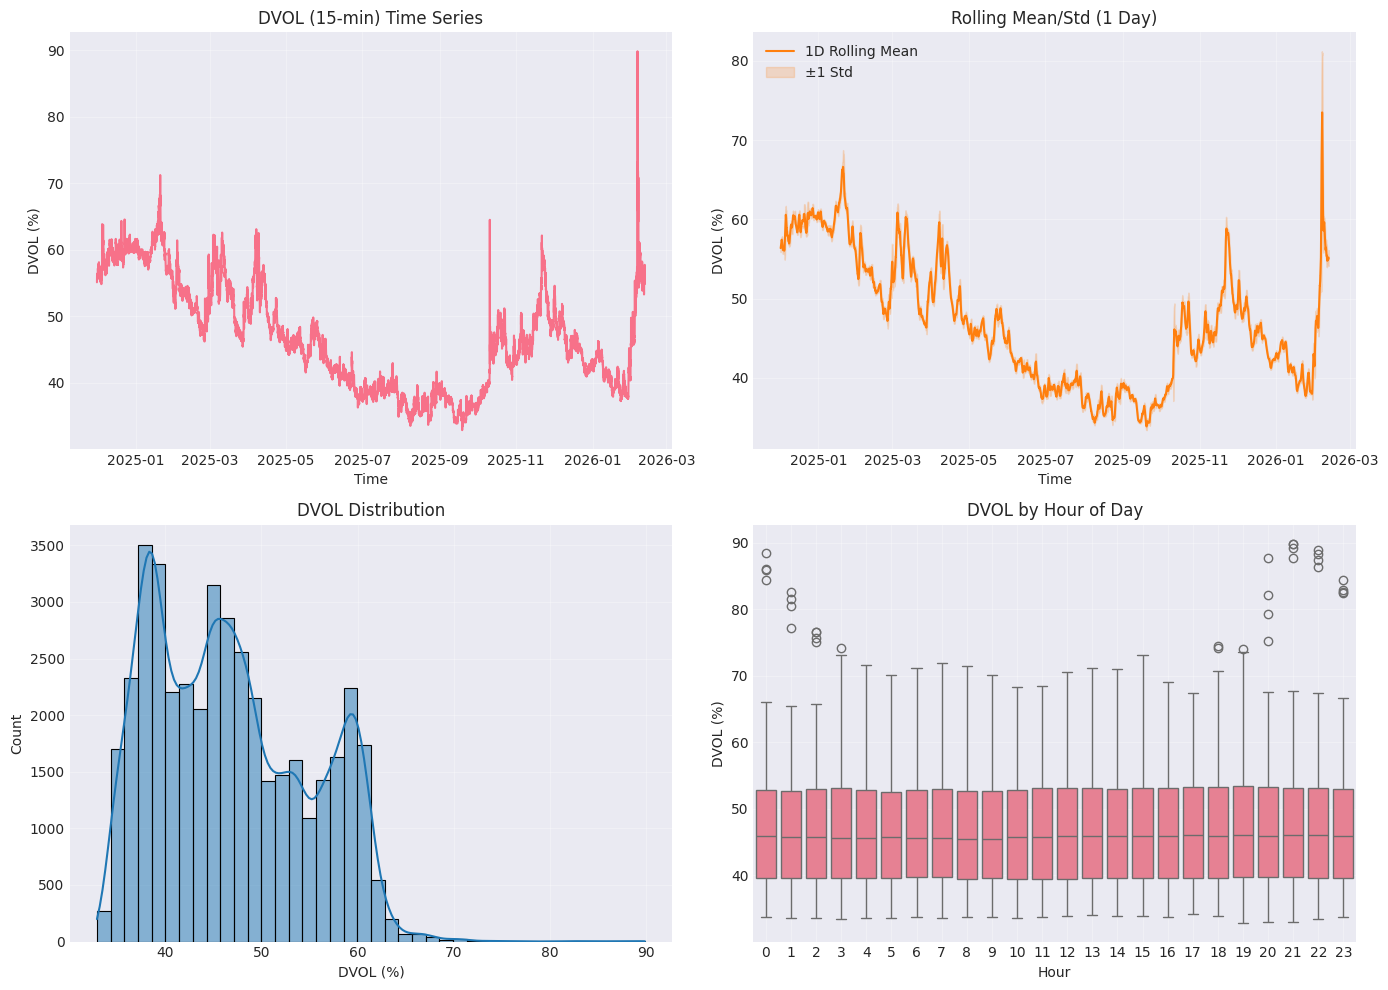


Missing Values:
open     0
high     0
low      0
close    0
dvol     0
dtype: int64


In [5]:
# Visualize DVOL time series and distributions

plot_df = df_dvol.copy()
if plot_df["timestamp"].dt.tz is not None:
    plot_df["timestamp"] = plot_df["timestamp"].dt.tz_convert(None)

# Rolling stats (1 day = 96 intervals of 15 minutes)
roll_window = 96
plot_df["dvol_roll_mean"] = plot_df["dvol"].rolling(roll_window).mean()
plot_df["dvol_roll_std"] = plot_df["dvol"].rolling(roll_window).std()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) DVOL over time
axes[0, 0].plot(plot_df["timestamp"], plot_df["dvol"], linewidth=1.5, label="DVOL (Close)")
axes[0, 0].set_title("DVOL (15-min) Time Series")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("DVOL (%)")
axes[0, 0].grid(True, alpha=0.3)

# 2) Rolling mean and std bands
axes[0, 1].plot(plot_df["timestamp"], plot_df["dvol_roll_mean"], color="tab:orange", label="1D Rolling Mean")
axes[0, 1].fill_between(
    plot_df["timestamp"],
    plot_df["dvol_roll_mean"] - plot_df["dvol_roll_std"],
    plot_df["dvol_roll_mean"] + plot_df["dvol_roll_std"],
    color="tab:orange", alpha=0.2, label="±1 Std"
  )
axes[0, 1].set_title("Rolling Mean/Std (1 Day)")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("DVOL (%)")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3) Distribution of DVOL
sns.histplot(plot_df["dvol"].dropna(), bins=40, kde=True, ax=axes[1, 0], color="tab:blue")
axes[1, 0].set_title("DVOL Distribution")
axes[1, 0].set_xlabel("DVOL (%)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].grid(True, alpha=0.3)

# 4) DVOL by hour of day
plot_df["hour"] = plot_df["timestamp"].dt.hour
sns.boxplot(x="hour", y="dvol", data=plot_df, ax=axes[1, 1])
axes[1, 1].set_title("DVOL by Hour of Day")
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("DVOL (%)")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for missing values in numeric columns
print("\nMissing Values:")
print(df_dvol[["open", "high", "low", "close", "dvol"]].isnull().sum())

# 3. Feature Engineering and Data Preparation

Create features for time-series prediction: lags, rolling statistics, and temporal features.

In [6]:
# Create lag features (past values as predictors)
def create_features(data, lags=[1, 2, 3, 7], horizon_steps=96):
    """
    Create lag and rolling features for time-series prediction.
    """
    df = data.copy()

    # Lag features
    for lag in lags:
        df[f"lag_{lag}"] = df["dvol"].shift(lag)

    # Rolling mean features
    for window in [3, 7, 14]:
        df[f"rolling_mean_{window}"] = df["dvol"].rolling(window=window).mean().shift(1)

    # Rolling std features
    for window in [3, 7, 14]:
        df[f"rolling_std_{window}"] = df["dvol"].rolling(window=window).std().shift(1)

    # Day of week and month (if applicable)
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["day_of_month"] = df["timestamp"].dt.day

    # Target: DVOL 24 hours ahead (96 steps for 15-min data)
    df["target_dvol"] = df["dvol"].shift(-horizon_steps)

    # Remove rows with NaN values (created by lag features)
    df = df.dropna()

    return df

# Create features
df_features = create_features(df_dvol)

print("Features Created:")
display(df_features.head(10))
print("\nFeature Columns:", df_features.columns.tolist())

Features Created:


,timestamp,open,high,low,close,dvol,lag_1,lag_2,lag_3,lag_7,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_std_3,rolling_std_7,rolling_std_14,day_of_week,day_of_month,target_dvol
14,2024-12-01 03:30:00+00:00,55.89,55.97,55.89,55.96,55.96,55.89,55.97,56.13,55.91,55.996667,56.075714,55.836429,0.122202,0.172999,0.365758,6,1,57.12
15,2024-12-01 03:45:00+00:00,55.96,55.96,55.92,55.96,55.96,55.96,55.89,55.97,56.10,55.940000,56.082857,55.895714,0.043589,0.165903,0.304598,6,1,57.21
16,2024-12-01 04:00:00+00:00,55.96,55.98,55.92,55.98,55.98,55.96,55.96,55.89,56.14,55.936667,56.062857,55.953571,0.040415,0.171825,0.216141,6,1,57.04
17,2024-12-01 04:15:00+00:00,55.98,56.13,55.98,56.12,56.12,55.98,55.96,55.96,56.39,55.966667,56.040000,55.990714,0.011547,0.170489,0.162928,6,1,57.23
18,2024-12-01 04:30:00+00:00,56.12,56.25,56.12,56.23,56.23,56.12,55.98,55.96,56.13,56.020000,56.001429,56.021429,0.087178,0.089336,0.140923,6,1,57.17
19,2024-12-01 04:45:00+00:00,56.23,56.32,56.23,56.32,56.32,56.23,56.12,55.98,55.97,56.110000,56.015714,56.047857,0.125300,0.117027,0.143000,6,1,57.28
20,2024-12-01 05:00:00+00:00,56.32,56.34,56.28,56.31,56.31,56.32,56.23,56.12,55.89,56.223333,56.065714,56.072857,0.100167,0.160816,0.158135,6,1,57.26
21,2024-12-01 05:15:00+00:00,56.31,56.33,56.24,56.33,56.33,56.31,56.32,56.23,55.96,56.286667,56.125714,56.100714,0.049329,0.162671,0.163400,6,1,57.21
22,2024-12-01 05:30:00+00:00,56.33,56.35,56.30,56.35,56.35,56.33,56.31,56.32,55.96,56.320000,56.178571,56.130714,0.010000,0.159940,0.164245,6,1,57.19
23,2024-12-01 05:45:00+00:00,56.35,56.37,56.31,56.31,56.31,56.35,56.33,56.31,55.98,56.330000,56.234286,56.148571,0.020000,0.137460,0.173952,6,1,57.06



Feature Columns: ['timestamp', 'open', 'high', 'low', 'close', 'dvol', 'lag_1', 'lag_2', 'lag_3', 'lag_7', 'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_14', 'rolling_std_3', 'rolling_std_7', 'rolling_std_14', 'day_of_week', 'day_of_month', 'target_dvol']


### OPTIONAL: Enrich features with BTC spot prices
Use the CrunchDAO PriceDB API to pull BTC spot prices (often higher frequency than 15-minute DVOL).
We align prices to DVOL timestamps via nearest-time matching, then add simple return and volatility features.

In [7]:
# Price Data Provider (from crunch-synth)
# https://github.com/crunchdao/crunch-synth/blob/main/crunch_synth/price_provider.py

from datetime import datetime
import requests

class PriceUnavailableError(ValueError):
    """Raised when the price provider cannot fetch the price for an asset."""
    pass

class PriceDbClient:
    _HISTORY_URL = "https://pricedb.crunchdao.com/v1/prices"
    
    def get_price_history(
        self,
        *,
        asset: str,
        from_: datetime,
        to: datetime,
        timeout=30,
    ) -> list[tuple[float, int]]:
        query = {
            "asset": asset,
            "from": from_.isoformat(),
            "to": to.isoformat(),
        }
        
        try:
            response = requests.get(
                self._HISTORY_URL,
                timeout=timeout,
                params=query,
            )
            
            response.raise_for_status()
            root = response.json()
        except Exception as error:
            raise PriceUnavailableError(f"Could not get price history for {asset}: {error}") from error
        
        return list(zip(root["timestamp"], root["close"]))

# Initialize the price data client
pricedb = PriceDbClient()

print("PriceDbClient initialized successfully!")

PriceDbClient initialized successfully!


In [8]:
# Fetch BTC price data to enrich our DVOL features
print("Fetching BTC price data...")

try:
    # Get the date range from our DVOL data
    start_date = df_dvol['timestamp'].min()
    end_date = df_dvol['timestamp'].max()
    
    print(f"Date range: {start_date} to {end_date}")
    
    # Fetch BTC price history
    btc_prices = pricedb.get_price_history(
        asset="BTC",
        from_=start_date.to_pydatetime(),
        to=end_date.to_pydatetime(),
    )
    
    print(f"Fetched {len(btc_prices)} BTC price data points")
    
    # Convert to DataFrame
    df_btc = pd.DataFrame(btc_prices, columns=['timestamp', 'btc_price'])
    df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'], unit='s', utc=True)
    
    # Ensure both timestamps have the same precision (convert both to ns for compatibility)
    df_btc['timestamp'] = df_btc['timestamp'].astype('datetime64[ns, UTC]')
    df_features_copy = df_features.copy()
    df_features_copy['timestamp'] = df_features_copy['timestamp'].astype('datetime64[ns, UTC]')
    
    # Merge BTC price data with our features
    # Using merge_asof to handle time alignment (nearest timestamp match)
    df_features_with_price = pd.merge_asof(
        df_features_copy.sort_values('timestamp'),
        df_btc.sort_values('timestamp'),
        on='timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('15min')  # Maximum time difference for matching
    )
    
    # Add price-based features
    df_features_with_price['btc_return_1'] = df_features_with_price['btc_price'].pct_change(1)
    df_features_with_price['btc_return_4'] = df_features_with_price['btc_price'].pct_change(4)  # 1 hour
    df_features_with_price['btc_volatility_96'] = df_features_with_price['btc_return_1'].rolling(96).std().shift(1)  # 24h volatility
    
    # Check how many rows have BTC price data
    price_coverage = df_features_with_price['btc_price'].notna().sum()
    print(f"BTC price coverage: {price_coverage}/{len(df_features_with_price)} rows ({price_coverage/len(df_features_with_price)*100:.1f}%)")
    
    # If we have good coverage (>50%), use the enriched features
    if price_coverage / len(df_features_with_price) > 0.5:
        # Fill any remaining NaN values in price features with forward fill then backward fill
        price_cols = ['btc_price', 'btc_return_1', 'btc_return_4', 'btc_volatility_96']
        df_features_with_price[price_cols] = df_features_with_price[price_cols].ffill().bfill()
        
        df_features = df_features_with_price
        print("✓ Successfully enriched features with BTC price data!")
        print(f"New feature columns: {[col for col in df_features.columns if 'btc' in col]}")
    else:
        print("⚠ Low BTC price coverage, continuing without price features")
        
except PriceUnavailableError as e:
    print(f"⚠ Could not fetch BTC price data: {e}")
    print("Continuing with DVOL features only")
except Exception as e:
    print(f"⚠ Unexpected error fetching price data: {e}")
    print("Continuing with DVOL features only")


print(f"\nFinal feature set size: {df_features.shape}")
print("Columns:", df_features.columns.tolist())

Fetching BTC price data...
Date range: 2024-12-01 00:00:00+00:00 to 2026-02-11 18:30:00+00:00
Fetched 630275 BTC price data points
BTC price coverage: 41914/41917 rows (100.0%)
✓ Successfully enriched features with BTC price data!
New feature columns: ['btc_price', 'btc_return_1', 'btc_return_4', 'btc_volatility_96']

Final feature set size: (41917, 23)
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'dvol', 'lag_1', 'lag_2', 'lag_3', 'lag_7', 'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_14', 'rolling_std_3', 'rolling_std_7', 'rolling_std_14', 'day_of_week', 'day_of_month', 'target_dvol', 'btc_price', 'btc_return_1', 'btc_return_4', 'btc_volatility_96']


# 4. Build and Train Your Model

Train a simple machine learning model to predict DVOL. You can expand this with more sophisticated approaches (ARIMA, LSTM, etc.).

In [9]:
# Split data into train and test sets (80/20 split)
train_size = int(len(df_features) * 0.8)

df_train = df_features[:train_size]
df_test = df_features[train_size:]

# Separate features and target
feature_cols = [col for col in df_features.columns if col not in ["timestamp", "dvol", "target_dvol"]]

X_train = df_train[feature_cols]
y_train = df_train["target_dvol"]

X_test = df_test[feature_cols]
y_test = df_test["target_dvol"]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")

Training set size: 33533
Test set size: 8384
Number of features: 20


In [10]:
# Train a Random Forest model
print("Training Random Forest model...")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully!")

# Evaluate on training set
train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)

print(f"\nTraining Performance:")
print(f"  MSE: {train_mse:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

# Evaluate on test set
test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)

print(f"\nTest Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

Training Random Forest model...
✓ Model trained successfully!

Training Performance:
  MSE: 1.8618
  RMSE: 1.3645

Test Performance:
  MSE: 9.7991
  RMSE: 3.1303


Top 10 Most Important Features:
            feature  importance
3             close    0.308371
10  rolling_mean_14    0.251591
2               low    0.179877
1              high    0.143899
8    rolling_mean_3    0.042375
9    rolling_mean_7    0.039366
5             lag_2    0.008215
15     day_of_month    0.005795
0              open    0.005771
4             lag_1    0.005493


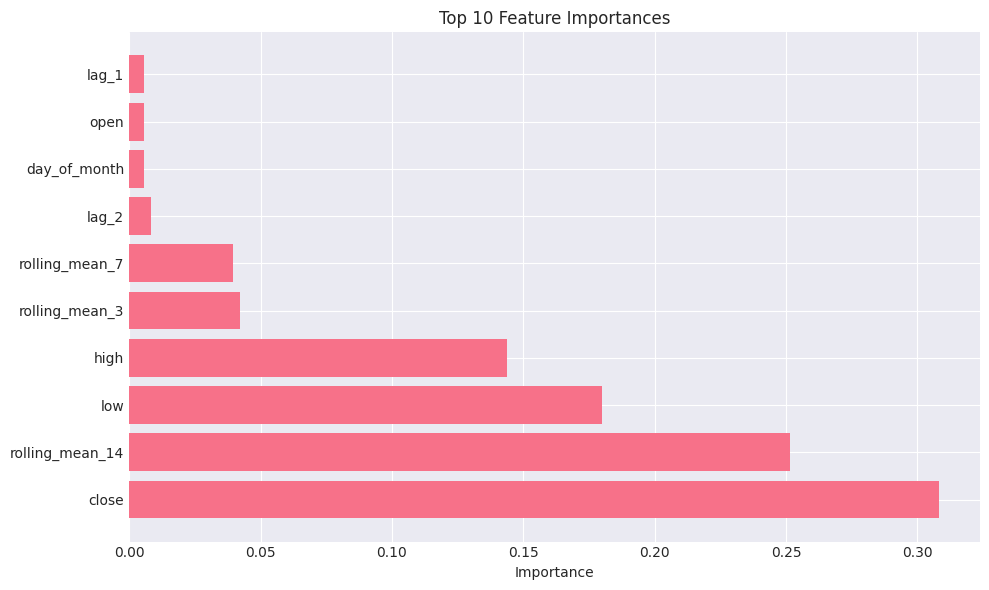

In [11]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(10), feature_importance['importance'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# 5. Make Predictions

Generate predictions for the test set and visualize the results.

Predictions Sample:
                  timestamp  actual  predicted     error
0 2025-11-15 10:45:00+00:00   48.86  47.941590  0.918410
1 2025-11-15 11:00:00+00:00   48.85  47.941590  0.908410
2 2025-11-15 11:15:00+00:00   49.03  47.941590  1.088410
3 2025-11-15 11:30:00+00:00   49.00  47.941590  1.058410
4 2025-11-15 11:45:00+00:00   48.99  47.929787  1.060213
5 2025-11-15 12:00:00+00:00   48.96  47.929787  1.030213
6 2025-11-15 12:15:00+00:00   48.91  47.929787  0.980213
7 2025-11-15 12:30:00+00:00   48.93  47.929787  1.000213
8 2025-11-15 12:45:00+00:00   48.80  47.929787  0.870213
9 2025-11-15 13:00:00+00:00   48.79  47.929787  0.860213


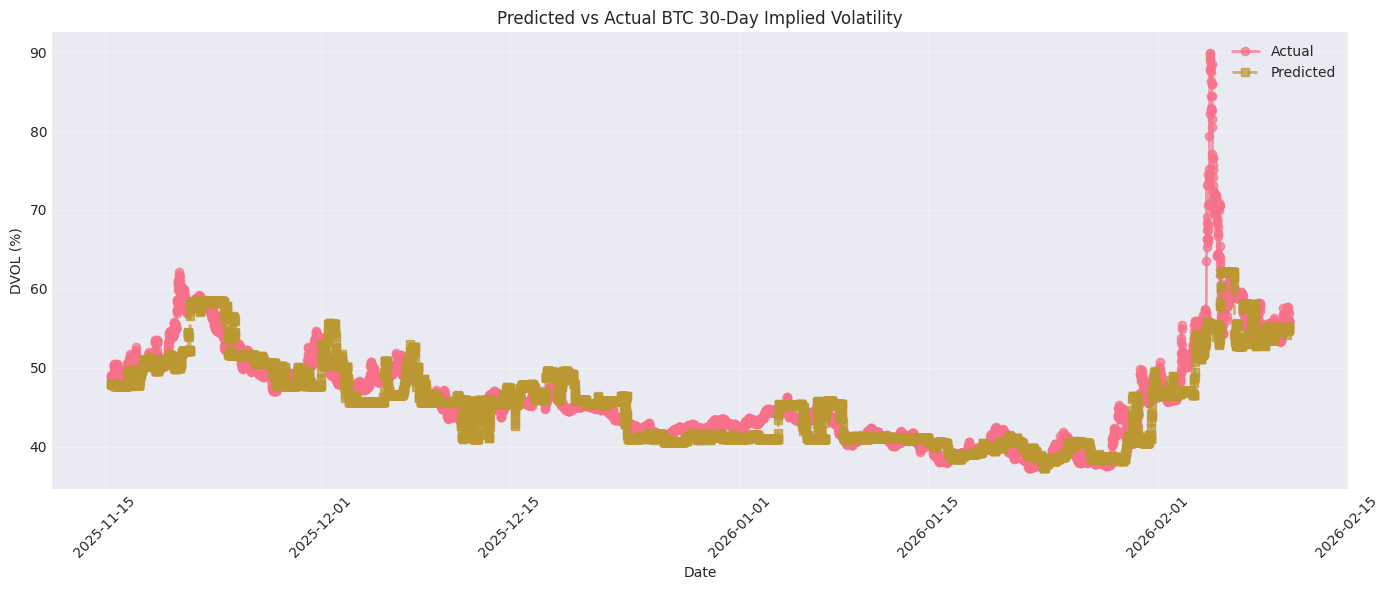

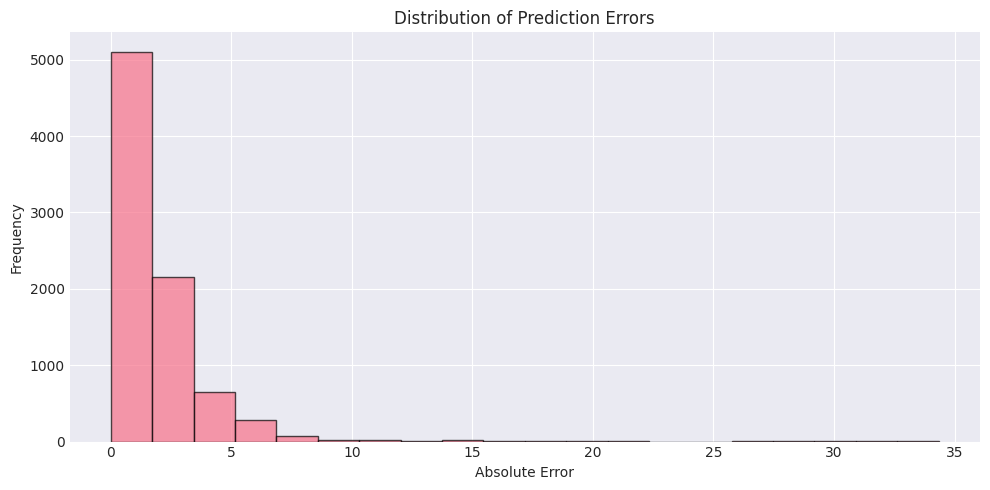

In [12]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'timestamp': df_test['timestamp'].reset_index(drop=True),
    'actual': y_test.reset_index(drop=True),
    'predicted': test_pred,
    'error': np.abs(y_test.reset_index(drop=True) - test_pred)
})

print("Predictions Sample:")
print(predictions_df.head(10))

# Visualize predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(predictions_df['timestamp'], predictions_df['actual'], 'o-', label='Actual', alpha=0.7, linewidth=2)
plt.plot(predictions_df['timestamp'], predictions_df['predicted'], 's--', label='Predicted', alpha=0.7, linewidth=2)
plt.xlabel('Date')
plt.ylabel('DVOL (%)')
plt.title('Predicted vs Actual BTC 30-Day Implied Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prediction error distribution
plt.figure(figsize=(10, 5))
plt.hist(predictions_df['error'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

# 6. Prepare Your Submission

Submissions run on the server. You can use the **btcvol** package (available on PyPI) to implement a tracker and validate it locally before uploading.

In [13]:
# Serialize trained model, scaler, and feature columns for submission
import base64
import pickle
import json

# Serialize model and scaler to base64
model_bytes = pickle.dumps(model)
model_b64 = base64.b64encode(model_bytes).decode('utf-8')

scaler_bytes = pickle.dumps(scaler)
scaler_b64 = base64.b64encode(scaler_bytes).decode('utf-8')

feature_cols_json = json.dumps(feature_cols)

print("✓ Model serialized successfully!")
print(f"Model size: {len(model_b64) / 1024:.1f} KB")
print(f"Scaler size: {len(scaler_b64) / 1024:.1f} KB")
print(f"Feature columns: {len(feature_cols)} features")


✓ Model serialized successfully!
Model size: 1246.4 KB
Scaler size: 1.6 KB
Feature columns: 20 features


In [14]:
# Save serialized artifacts to resources/ for submission packaging
from pathlib import Path

resources_dir = Path("resources")
resources_dir.mkdir(parents=True, exist_ok=True)

(resources_dir / "model.pkl").write_bytes(model_bytes)
(resources_dir / "scaler.pkl").write_bytes(scaler_bytes)
(resources_dir / "feature_cols.json").write_text(feature_cols_json)

print(f"✓ Wrote model.pkl, scaler.pkl, feature_cols.json to {resources_dir.resolve()}")


✓ Wrote model.pkl, scaler.pkl, feature_cols.json to /home/jeremy/crunch-btcdvol/notebooks/resources


In [ ]:
# Submission-ready RandomForest tracker with live feature engineering in predict()
import numpy as np
import pandas as pd
import base64
import pickle
import json
from pathlib import Path
from btcvol import TrackerBase


class MyTracker(TrackerBase):
    """
    Random Forest tracker with embedded model.
    Uses TrackerBase methods that fetch from cache (production) or APIs (local).
    """

    # Class variables for embedded serialized model (populated after training)
    _MODEL_B64 = None
    _SCALER_B64 = None
    _FEATURE_COLS_JSON = None

    def __init__(self):
        """Initialize tracker with embedded model and scaler."""
        super().__init__()  # Initialize TrackerBase caches
        
        # Try to use notebook globals first (development mode)
        if 'model' in globals() and 'scaler' in globals() and 'feature_cols' in globals():
            self.model = globals()['model']
            self.scaler = globals()['scaler']
            self.feature_cols = globals()['feature_cols']
            
            # Populate caches from notebook data for local testing
            if 'df_dvol' in globals():
                dvol_df = globals()['df_dvol'][['timestamp', 'dvol']].copy()
                self._dvol_cache['BTC'] = dvol_df
            if 'df_btc' in globals():
                price_df = globals()['df_btc'].copy()
                price_df = price_df.rename(columns={'btc_price': 'price'})
                self._price_cache['BTC'] = price_df
            
            return

        # Try to load from resources/ (submission mode with files)
        resources_dir = Path(__file__).parent / "resources"
        model_path = resources_dir / "model.pkl"
        scaler_path = resources_dir / "scaler.pkl"
        features_path = resources_dir / "feature_cols.json"
        if model_path.exists() and scaler_path.exists() and features_path.exists():
            with model_path.open("rb") as f:
                self.model = pickle.load(f)
            with scaler_path.open("rb") as f:
                self.scaler = pickle.load(f)
            self.feature_cols = json.loads(features_path.read_text())
            return

        # Otherwise use embedded serialized data (submission mode with base64)
        if self._MODEL_B64 and self._SCALER_B64 and self._FEATURE_COLS_JSON:
            self.model = pickle.loads(base64.b64decode(self._MODEL_B64))
            self.scaler = pickle.loads(base64.b64decode(self._SCALER_B64))
            self.feature_cols = json.loads(self._FEATURE_COLS_JSON)
            return

        raise RuntimeError("Model, scaler, or feature_cols not found. Provide resources or embed base64.")

    def _create_features_from_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Create lag and rolling features from merged price/dvol data.
        Mirrors the create_features function used during training.
        """
        df = data.copy()
        
        # Ensure we have required columns
        if 'dvol' not in df.columns:
            raise ValueError("Missing 'dvol' column in data")

        # Lag features
        for lag in [1, 2, 3, 7]:
            df[f"lag_{lag}"] = df["dvol"].shift(lag)

        # Rolling mean features
        for window in [3, 7, 14]:
            df[f"rolling_mean_{window}"] = df["dvol"].rolling(window=window).mean().shift(1)

        # Rolling std features
        for window in [3, 7, 14]:
            df[f"rolling_std_{window}"] = df["dvol"].rolling(window=window).std().shift(1)

        # Day of week and month
        df["day_of_week"] = df["timestamp"].dt.dayofweek
        df["day_of_month"] = df["timestamp"].dt.day

        # BTC price-based features (if price column exists)
        if 'price' in df.columns:
            df["btc_price"] = df["price"]
            df["btc_return_1"] = df["btc_price"].pct_change(1)
            df["btc_return_4"] = df["btc_price"].pct_change(4)
            df["btc_volatility_96"] = df["btc_return_1"].rolling(96).std().shift(1)

        # Fill NaN values
        df = df.ffill().bfill()
        
        # Ensure all required feature columns exist
        for col in self.feature_cols:
            if col not in df.columns:
                df[col] = 0.0

        return df

    def predict(self, asset: str, horizon: int, step: int):
        """
        Generate volatility predictions using RandomForest model.
        Fetches data via TrackerBase methods (cache first, then APIs).
        """
        n_steps = max(1, horizon // step)

        try:
            # Fetch price data via TrackerBase (cache or CrunchDAO API)
            df_prices = self.fetch_price_data(asset)
            
            # Fetch DVOL data via TrackerBase (cache or Deribit API)
            df_dvol = self.fetch_latest_dvol_data(step=step)
            
            if df_dvol is None or df_dvol.empty:
                raise ValueError("No DVOL data available")

            # Merge price and DVOL data
            if not df_prices.empty:
                data = df_dvol.merge(df_prices, on="timestamp", how="inner")
            else:
                data = df_dvol  # Use DVOL-only features if no price data

            if data.empty or len(data) < 20:
                raise ValueError("Insufficient data after merge")

            # Create features from merged data
            df_features = self._create_features_from_data(data)
            
            # Get the most recent row with all features
            latest = df_features.iloc[-1:][self.feature_cols].copy()
            latest = latest.replace([np.inf, -np.inf], np.nan).fillna(0.0)
            
            # Make prediction
            X_scaled = self.scaler.transform(latest)
            pred_vol_pct = float(self.model.predict(X_scaled)[0])

        except Exception as e:
            # Development fallback if notebook features are available
            try:
                if 'df_features' in globals():
                    X = globals()['df_features'].iloc[-1:][self.feature_cols]
                    X_scaled = self.scaler.transform(X)
                    pred_vol_pct = float(self.model.predict(X_scaled)[0])
                else:
                    # Final fallback: use dummy features
                    X_dummy = np.zeros((1, len(self.feature_cols)))
                    X_scaled = self.scaler.transform(X_dummy)
                    pred_vol_pct = float(self.model.predict(X_scaled)[0])
            except Exception:
                pred_vol_pct = 50.0

        # Clamp to reasonable range (0-100%)
        pred_vol_pct = max(0, min(100, pred_vol_pct))

        # Convert to decimal (0-1 scale)
        pred_vol_decimal = pred_vol_pct / 100.0

        # Return same prediction for all steps
        return [float(pred_vol_decimal)] * n_steps


# Auto-populate embedded model/scaler from serialized data
try:
    MyTracker._MODEL_B64 = model_b64
    MyTracker._SCALER_B64 = scaler_b64
    MyTracker._FEATURE_COLS_JSON = feature_cols_json
    print("✓ Embedded RandomForest model, scaler, and features into MyTracker")
except NameError:
    print("⚠ Serialized data not available (run serialization cell first)")


✓ Embedded RandomForest model, scaler, and features into MyTracker


In [17]:
# Local validation (checks shape, numeric values, and reasonable range)
validation_ok = test_model_locally(MyTracker)
print("Validation passed:", validation_ok)

# Sanity check: sample outputs
tracker = MyTracker()
print(tracker.predict(asset="BTC", horizon=3600, step=900))
print(tracker.predict(asset="BTC", horizon=86400, step=900))


BTC DVOL Model Local Testing

✓ Model instantiation: PASSED
✓ Predict method exists: PASSED
✓ 1-hour predictions (4 values): PASSED
  Sample predictions: [0.44630730748667496, 0.44630730748667496, 0.44630730748667496, 0.44630730748667496]
✓ 24-hour predictions (96 values): PASSED
  Sample predictions: [0.44630730748667496, 0.44630730748667496, 0.44630730748667496, 0.44630730748667496, 0.44630730748667496]...

✓ All tests passed!

Your model is ready for submission to the competition.
Next steps:
  1. Review your predictions to ensure they make sense
  2. Test with historical data if available
  3. Submit to the competition platform

Validation passed: True
[0.44630730748667496, 0.44630730748667496, 0.44630730748667496, 0.44630730748667496]
[0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0.446307307486675, 0

In [18]:
# Debug: Check tracker cache initialization
tracker_debug = MyTracker()
print("=== Tracker Cache Status ===")
print(f"DVOL cache keys: {list(tracker_debug._dvol_cache.keys())}")
print(f"Price cache keys: {list(tracker_debug._price_cache.keys())}")

if 'BTC' in tracker_debug._dvol_cache:
    dvol_cache = tracker_debug._dvol_cache['BTC']
    print(f"\nDVOL cache shape: {dvol_cache.shape}")
    print(f"DVOL cache columns: {dvol_cache.columns.tolist()}")
    print(f"DVOL cache date range: {dvol_cache['timestamp'].min()} to {dvol_cache['timestamp'].max()}")
    print(f"Sample DVOL cache:\n{dvol_cache.head()}")
else:
    print("⚠ No DVOL cache found!")

if 'BTC' in tracker_debug._price_cache:
    price_cache = tracker_debug._price_cache['BTC']
    print(f"\nPrice cache shape: {price_cache.shape}")
    print(f"Price cache columns: {price_cache.columns.tolist()}")
    print(f"Sample price cache:\n{price_cache.head()}")
else:
    print("⚠ No price cache found!")


=== Tracker Cache Status ===
DVOL cache keys: ['BTC']
Price cache keys: ['BTC']

DVOL cache shape: (42027, 2)
DVOL cache columns: ['timestamp', 'dvol']
DVOL cache date range: 2024-12-01 00:00:00+00:00 to 2026-02-11 18:30:00+00:00
Sample DVOL cache:
                  timestamp   dvol
0 2024-12-01 00:00:00+00:00  55.13
1 2024-12-01 00:15:00+00:00  55.15
2 2024-12-01 00:30:00+00:00  55.46
3 2024-12-01 00:45:00+00:00  55.69
4 2024-12-01 01:00:00+00:00  55.86

Price cache shape: (630275, 2)
Price cache columns: ['timestamp', 'price']
Sample price cache:
                  timestamp         price
0 2024-12-01 00:00:00+00:00  96428.033153
1 2024-12-01 00:01:00+00:00  96405.719696
2 2024-12-01 00:02:00+00:00  96469.713205
3 2024-12-01 00:03:00+00:00  96546.092740
4 2024-12-01 00:04:00+00:00  96561.375301


# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. **Download your resources folder with all required files (model.pkl, scaler.pkl, feature_cols.json)** 
3. Upload your Notebook and resources folder to the platform
4. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/btcdvol/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)

# 💡 Recommendations for Improvement
## Model Enhancements
- Try other models like **XGBoost, LightGBM, or Neural networks**
- Use **TimeSeriesSplit** for proper cross-validation
- Ensemble multiple models with weighted averaging
## Feature Engineering
- Add more **lag features** (14, 21, 30 periods)
- Add **volatility-specific features**: realized volatility, Parkinson estimator, vol-of-vol...
- Consider **external signals**: VIX (S&P 500 volatility), funding rates
## Have fun!